# OpenAI - Request for Research 2.0 (https://blog.openai.com/requests-for-research-2/)

## Warmup

   Train an LSTM to solve the XOR problem: that is, given a sequence of bits, determine its parity. The LSTM should consume the sequence, one bit at a time, and then output the correct answer at the sequence’s end. Test the two approaches below:

 *  Generate a dataset of random 100,000 binary strings of length 50. Train the LSTM; what performance do you get?

 *  Generate a dataset of random 100,000 binary strings, where the length of each string is independently and randomly chosen between 1 and 50. Train the LSTM. Does it succeed? What explains the difference?


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import inspect
import torch.utils.data as data_utils
import pdb
import random
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch.nn.utils.rnn as rnn_utils
torch.manual_seed(0)  

## Generating Bits String

In [3]:
def generate_binary(length=1, num=1):
    inputs = []
    targets = []
    for i in range(0, int(round(num))):
        sum = 0
        input = []
        target = []
        for j in range(0, int(round(length))):
            temp = random.randint(0, 1)
            sum += temp
            current_input = np.zeros(2)
            current_input[temp] = 1
            input.append(current_input)
            target.append(sum % 2)
        inputs.append(input)
        targets.append(target)
    inputs = torch.Tensor(inputs)
    targets = torch.Tensor(targets).unsqueeze(2)
    return inputs, targets

def collate_generate(sequencelength=50, batchsize=2, is_variable_length=False):
    def pad_collate(batch):
        data = [item[0][0:sequencelength] for item in batch]
        target = [item[1][0:sequencelength] for item in batch]
        length = len(data[0])
        
        lengths_vector = [random.randint(1,length) if is_variable_length else length for i in range(0, batchsize)]
        lengths_vector.sort(reverse=True)
        
        data = rnn_utils.pack_padded_sequence(torch.stack(data), lengths_vector, batch_first=True)
        target = rnn_utils.pack_padded_sequence(torch.stack(target), lengths_vector, batch_first=True)
        return [data, target]
    return pad_collate

def flatten(S):
    if S == []:
        # terminal condition
        return S
    elif isinstance(S[0], list):
        # first element is list
        return flatten(S[0]) + flatten(S[1:])
    else:
        # first element is not a list
        return S[:1] + flatten(S[1:])
    
#i, t = generate_binary(length=50, num=20)
#print (i[0][0:50].shape)
'''
print (rnn_utils.pad_packed_sequence(i, batch_first=True)[0])
print (rnn_utils.pad_packed_sequence(i, batch_first=True)[1])
print (rnn_utils.pad_packed_sequence(t, batch_first=True)[0])
print (rnn_utils.pad_packed_sequence(t, batch_first=True)[1])
'''

'\nprint (rnn_utils.pad_packed_sequence(i, batch_first=True)[0])\nprint (rnn_utils.pad_packed_sequence(i, batch_first=True)[1])\nprint (rnn_utils.pad_packed_sequence(t, batch_first=True)[0])\nprint (rnn_utils.pad_packed_sequence(t, batch_first=True)[1])\n'

# Single Layer LSTM Model

In [4]:
class LSTMModel(nn.Module):
    def __init__(self, feature_size, hidden_size):
        super(LSTMModel, self).__init__()
        self.feature_size = feature_size
        self.hidden_size = hidden_size
        
        self.rnn = nn.LSTM(
            input_size=feature_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True)
        self.h2o = nn.Linear(hidden_size, 1)
        self.sig = nn.Sigmoid()

    def unpacked(self, hidden):
        if isinstance(hidden, torch.nn.utils.rnn.PackedSequence):
            hidden, lengths_vector = rnn_utils.pad_packed_sequence(hidden, batch_first=True)
        return hidden
        
    def forward(self, inputs):
        h, h_and_c = self.rnn(inputs)
        h = self.unpacked(h)
        outputs = self.h2o(h)
        return outputs, self.sig(outputs)
    
    '''
    def forward(self, inputs, hiddens):
        h, h_and_c = self.rnn(inputs, hiddens)
        h = self.unpacked(h)
        outputs = self.h2o(h)
        return outputs, self.sig(outputs), h_and_c
    
    '''

    def initRandomHidden(self, batch_size=1):
        h = torch.zeros(1, batch_size, self.hidden_size)
        c = torch.zeros(1, batch_size, self.hidden_size)
        return [h, c]

# Training with fixed length 50
 *  Generate a dataset of random 100,000 binary strings of length 50. Train the LSTM; what performance do you get?


* batch size 20
* Vanilla SGD with learning rate 1
* Cross Entropy Loss
* Achieve 100 % with 2 hidden units after ~2 epochs

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot([(curr - prev) / prev for prev, curr in zip(gradient_vector, gradient_vector[1:])])

In [ ]:
gradient_vector = []
max_length = 50

model = LSTMModel(2, 2)

# for short to long
inputs, targets = generate_binary(length=max_length, num=10000)
print (inputs.shape)
for length in range(1, max_length):
    model.zero_grad()
    
    input = inputs[:, (max_length - length):,  :]
    target = targets[:, (max_length - length):,  :]
    
    outputs, _ = model(input)
    loss = criterion(outputs, target).backward()
    
    gradient_vector.append(model.rnn.weight_ih_l0.grad.abs().sum())

In [ ]:
print_every = 300
epochs = 8
num_observation = 100000
num_test_observation = 1000

hidden_size = 2
batch_size = 20

criterion = nn.BCEWithLogitsLoss(reduction='elementwise_mean')

def evaluate(model, test_length=50, num_samples=num_test_observation, is_variable_length=True):
    accuracy = 0
    evaluate_criterion = nn.BCEWithLogitsLoss()
    
    inputs, targets = generate_binary(length=test_length, num=num_samples)
    dataset = torch.utils.data.TensorDataset(inputs, targets)
    
    loss = 0
    
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=1,
        drop_last=True,
        collate_fn=collate_generate(sequencelength=test_length, batchsize=batch_size, is_variable_length=is_variable_length),
        pin_memory=True)

    
    for batch_idx, data in enumerate(dataloader, 1):
        input, target = data        
        output_tensor, predict_tensor = model(input)

        # unpack
        target_tensor, lengths_vector = rnn_utils.pad_packed_sequence(target, batch_first=True)
        
        # pack
        predict = rnn_utils.pack_padded_sequence(predict_tensor, lengths_vector, batch_first=True)
        output = rnn_utils.pack_padded_sequence(output_tensor, lengths_vector, batch_first=True)
            
        loss += evaluate_criterion(output.data, target.data)
        
        # we only care the final output of each string which is at index i-1 for i in lengths_vector
        for idx_in_batch, idx_in_sequence in enumerate(lengths_vector.tolist(), 0):
            accuracy += ((predict_tensor[idx_in_batch, idx_in_sequence-1] > 0.5).numpy() ==  target_tensor[idx_in_batch, idx_in_sequence-1].numpy())
        
    print (accuracy[0] / num_samples * 100, "%")
    return loss / num_samples


'''
Training
'''
lr = 1

model_list = []
curriculum = [(i, False) for i in range(1, 50, 8)]
#curriculum = [(10, False)]

# compare different training sets
parameter_trackers = {}
parameter_gradient_trackers = {}
losses_dict = {}
gradient_abs_sum_tracker = {}
gradient_abs_sum_list = []

''' training data '''
inputs, targets = generate_binary(length=50, num=num_observation)
dataset = torch.utils.data.TensorDataset(inputs, targets)

for idx, curriculum_set in enumerate(curriculum): 
    length, is_random = curriculum_set
    
    model = LSTMModel(2, hidden_size)
    
    # tracking training statistics
    losses = []
    gradient_sample_sum = []
    gradient_abs_sum = 0
    generalization_losses = []
    parameter_track  = []
    parameter_gradient_track  = []
    
    
    ''' training dataloader '''
    dataloader = torch.utils.data.DataLoader(
                    dataset,
                    batch_size=batch_size,
                    shuffle=True,
                    num_workers=1,
                    drop_last=True,
                    collate_fn=collate_generate(sequencelength=length, batchsize=batch_size,  is_variable_length=is_random),
                    pin_memory=True)

    print ("learning rate {}, batch size {}, training length {}".format(lr, batch_size, length))
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    for i in range(1, epochs+1):    
        running_loss = 0
        for batch_idx, data in enumerate(dataloader, 1):
            optimizer.zero_grad()
            
            input, target = data
            output, _ = model(input)
            
            # unpack targets PackedSequence to get  variable length vector
            _, lengths_vector = rnn_utils.pad_packed_sequence(target, batch_first=True)
    
            # use pack_padded_sequence function to flatten output according to variable length vector
            output = rnn_utils.pack_padded_sequence(output, lengths_vector, batch_first=True)
            
            #loss = criterion(outputs.data[-1].unsqueeze(0), targets.data[-1].unsqueeze(0))
            loss = criterion(output.data, target.data)
            
            losses.append(loss)
            
            running_loss += loss
            
            loss.backward()
            
            parameter_track.append(flatten(model.rnn.weight_ih_l0.detach().tolist()))
            parameter_gradient_track.append(flatten(model.rnn.weight_ih_l0.grad.detach().tolist()))
            gradient_sample_sum.append(model.rnn.weight_ih_l0.grad.abs().sum())
            gradient_abs_sum += model.rnn.weight_ih_l0.grad.abs().sum()
            
            optimizer.step()
            
            if batch_idx % print_every == 0:
                print ("epoch {}, batch {}, loss {}".format(i, batch_idx, running_loss / print_every))
                
                if running_loss / print_every < 1e-2:
                    running_loss = 0
                    break
                running_loss = 0
        
        print ("Accuracy: ")
        generalization_losses.append(evaluate(model, test_length=50, num_samples=100, is_variable_length=False))
        
    print ('#' * 100, '\nTestSet Accuracy:')
    evaluate(model, test_length=50, num_samples=num_test_observation, is_variable_length=False)
    
    gradient_abs_sum_tracker[curriculum_set] = gradient_sample_sum
    losses_dict[curriculum_set] = losses
    parameter_trackers[curriculum_set] = parameter_track
    parameter_gradient_trackers[curriculum_set] = parameter_gradient_track
    gradient_abs_sum_list.append(gradient_abs_sum)
    model_list.append(model)

learning rate 1, batch size 20, training length 1
epoch 1, batch 300, loss 0.067789226770401
epoch 1, batch 600, loss 0.0031909027602523565
Accuracy: 
57.99999999999999 %
epoch 2, batch 300, loss 0.0016259318217635155
Accuracy: 
50.0 %
epoch 3, batch 300, loss 0.0010597648797556758
Accuracy: 
55.00000000000001 %
epoch 4, batch 300, loss 0.0007765972404740751
Accuracy: 
51.0 %
epoch 5, batch 300, loss 0.0006081059691496193
Accuracy: 
52.0 %
epoch 6, batch 300, loss 0.0004997303476557136
Accuracy: 
57.99999999999999 %
epoch 7, batch 300, loss 0.0004236185923218727
Accuracy: 
54.0 %
epoch 8, batch 300, loss 0.00036612810799852014
Accuracy: 
47.0 %
#################################################################################################### 
TestSet Accuracy:
51.0 %
learning rate 1, batch size 20, training length 9
epoch 1, batch 300, loss 0.6920655369758606
epoch 1, batch 600, loss 0.6831150650978088
epoch 1, batch 900, loss 0.3302973210811615
epoch 1, batch 1200, loss 0.0218416191

Training the same network on 100000 bits string with length with 2, 5, 12, 25, 50, 100 respectively and test it on 10000 bits string with variable lengths between 1 and 50. 
Two observations.
1. Shorter the string, easier the training. Probably because to get the correct parity, network needs to memorize each bit in the string. Longer dependency is harder to learn due to gradient explosion through bptt.
2. Loss stays still then sudden drops to zero.


In [ ]:
# parameter track

import seaborn as sns
sns.set(color_codes=True)

for k in curriculum:
    fig, ax = plt.subplots(figsize=(20, 10))
    plt.plot(parameter_trackers[k])


for k in curriculum:
    fig, ax = plt.subplots(figsize=(20, 10))
    plt.plot(parameter_gradient_trackers[k])


fig, ax = plt.subplots(figsize=(20, 10))
legends = []
for k in curriculum:
    plt.plot(gradient_abs_sum_tracker[k])
    legends.append(k)
plt.legend(legends)

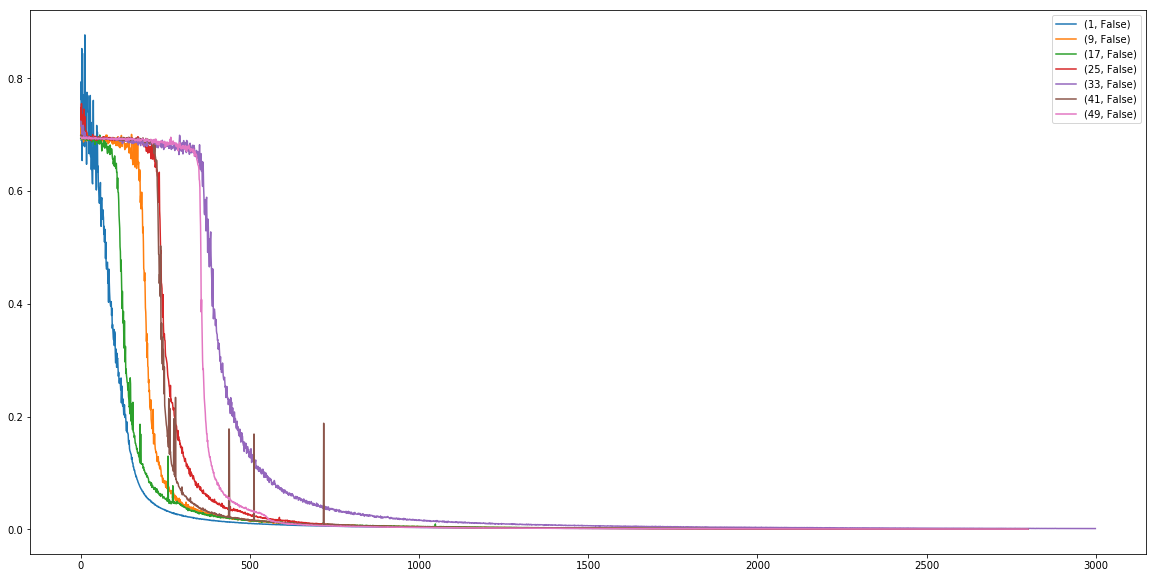

In [14]:
# loss

fig, ax = plt.subplots(figsize=(20, 10))
legends = []
for k,v in losses_dict.items():
    plt.plot(v)
    legends.append(k)
plt.legend(legends)

In [ ]:
import sty
from sty import fg, bg, ef, rs

def redness(text, color):
    return bg(255, color, color) + text + bg.rs

def blueness(text, color):
    return bg(color, color, 255) + text + bg.rs

def greeness(text, color):
    return bg(color, 255, color) + text + bg.rs

def norm(array):
    max_ = max(array)
    min_ = min(array)
    return [(e - min_) / (max_ - min_) for e in array]

In [ ]:
length_ = 10
input, target = generate_binary(length=length_, num=1)
hiddens = model.initRandomHidden()
output, predict = model(input, hiddens)

In [ ]:
hiddens = model.initRandomHidden()

h1array = []
h2array = []
c1array = []
c2array = []

h1str = ""
h2str = ""
c1str = ""
c2str = ""

s = ""

base = 255
for ii in range(1, length_+1):
    h, h_and_c = model.rnn(input[:, :ii, :], hiddens)
    h1 = h_and_c[0][0, 0, 0].data.numpy()
    h2 = h_and_c[0][0, 0, 1].data.numpy()
    c1 = h_and_c[1][0, 0, 0].data.numpy()
    c2 = h_and_c[1][0, 0, 1].data.numpy()
    h1array.append(h1)
    h2array.append(h2)
    c1array.append(c1)
    c2array.append(c2)
    
    

h1array = norm(h1array)
h2array = norm(h2array)
c1array = norm(c1array)
c2array = norm(c2array)
for ii in range(1, length_+1):
    char = str(int(input[0, ii-1, 1].data.numpy()))
    h1str += redness(char, int(h1array[ii-1] * base))
    h2str += redness(char, int(h2array[ii-1] * base))
    c1str += redness(char, int(c1array[ii-1] * base))
    c2str += redness(char, int(c2array[ii-1] * base))

print (h1str)
print (h2str)
print (c1str)
print (c2str)

# Training with variable length in [1,50]

* batch size 20
* Vanilla SGD with learning rate 1
* Binary Cross Entropy Loss

Training the same network on 100000 bits string with length with 50 and test it on 10000 bits string with variable lengths between 1 and 50. 
Compared to training with fixed size strings, network is easier to learn with variable length strings, probably because short dependency and combination curriculum.

### todo: 
1. investigate long dependency learning problems
2. curriculum learning for better training loss/generalization error



In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
legends = []
for k in curriculum:
    plt.plot(np.cumsum(gradient_abs_sum_tracker[k]))
    legends.append(k)
plt.legend(legends)
gradient_abs_sum_list

10

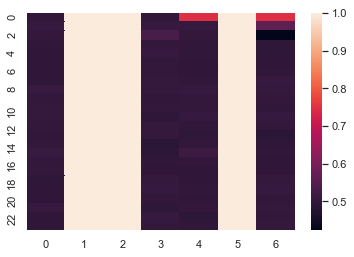

In [23]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
uniform_data = np.random.rand(10, 12)
ax = sns.heatmap(data)
len(uniform_data)

In [21]:
len(data)

24

In [22]:
def evaluate(length, model, inputs, targets):
    accuracy = 0
    num_samples = inputs.shape[0]
    batch_size = num_samples
    evaluate_criterion = nn.BCEWithLogitsLoss()
    
    dataset = torch.utils.data.TensorDataset(inputs, targets)
    
    loss = 0
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=1,
        drop_last=True,
        collate_fn=collate_generate(sequencelength=length, batchsize=batch_size, is_variable_length=False),
        pin_memory=True)

    
    for batch_idx, data in enumerate(dataloader, 1):
        input, targets = data
        
        outputs, predicts = model(input) 
        
        # unpack
        targets, lengths_vector = rnn_utils.pad_packed_sequence(targets, batch_first=True)
        loss += evaluate_criterion(outputs.data, targets.data)
    
        ## ??? mistake ?? 
        for idx_in_batch, idx_in_sequence in enumerate(lengths_vector.tolist(), 0):
            accuracy += ((predicts[idx_in_batch, idx_in_sequence-1] > 0.5).numpy() ==  targets[idx_in_batch, idx_in_sequence-1].numpy())
        
    print (accuracy[0] / num_samples * 100, "%")
    return accuracy[0] / num_samples

max_length = 50
inputs, targets = generate_binary(length=max_length, num=10000)
data = []
for i in range(2, 50, 2):
    buff = []
    for model in model_list:
        buff.append(evaluate(i, model, inputs, targets))
    print ("#" * 100)
    data.append(buff)

49.81 %
100.0 %
100.0 %
49.81 %
74.7 %
100.0 %
74.7 %
####################################################################################################
50.449999999999996 %
100.0 %
100.0 %
50.449999999999996 %
50.449999999999996 %
100.0 %
56.31 %
####################################################################################################
50.06 %
100.0 %
100.0 %
53.580000000000005 %
50.06 %
100.0 %
42.34 %
####################################################################################################
49.9 %
100.0 %
100.0 %
50.03999999999999 %
49.9 %
100.0 %
49.4 %
####################################################################################################
49.74 %
100.0 %
100.0 %
50.86000000000001 %
49.79 %
100.0 %
49.370000000000005 %
####################################################################################################
49.49 %
100.0 %
100.0 %
50.0 %
49.61 %
100.0 %
49.74 %
############################################################################

In [25]:
len(model_list)

7